In [134]:
import numpy as np
import matplotlib.pyplot as plt
import transforms3d as t3d
import itertools
from tqdm import tqdm

In [135]:
#good optimizers:
#https://nlopt.readthedocs.io/en/latest/
#pagmo / pygmo

#mystic might be the best: https://github.com/uqfoundation/mystic 
#http://trac.mystic.cacr.caltech.edu/project/mystic/wiki.html

In [136]:
from sklearn.metrics import mean_squared_error

def convert_quat_and_cart_to_homogeneous(q, xyz):
    T = np.eye(4)
    T[:3,:3] = t3d.quaternions.quat2mat(q)
    T[:3,3] = xyz
    return T

def generate_random_homogeneous_transform():
    q = np.random.dirichlet([1.3, 1.3, 1.3, 1.3], size = 1).squeeze()
    xyz = np.random.rand(3)
    return convert_quat_and_cart_to_homogeneous(q, xyz)

def list_permuter(list1, list2):
    #subitem for item in a for subitem in (item if isinstance(item, list) else [item])
    return [[subitem for item in pair for subitem in (item if isinstance(item, list) else [item])] for
            pair in itertools.product(list1,list2)]



In [137]:
#define all the points of the object
alpha = 0.05

point_positions = np.array([[1, -1, 0],[-1, -1, 0], [-1, 1, 0],[1, 0, -1],[-np.cos(np.pi/3), -np.sin(np.pi/3), -1],
                            [-np.cos(np.pi/3), np.sin(np.pi/3), -1]]).T

point_positions_noisy = point_positions + np.random.normal(loc=0.0, scale=alpha, size = point_positions.shape)

In [138]:
T = generate_random_homogeneous_transform()

point_positions = np.vstack([point_positions, np.ones(6)])
point_positions_noisy = np.vstack([point_positions_noisy, np.ones(6)])
point_positions_noisy_transformed = T @ point_positions_noisy

point_permutations = np.array(list(itertools.permutations(list(range(6)), 6)))

In [147]:
print(point_positions_noisy_transformed[:,point_permutations[0,:]])
print(point_positions_noisy_transformed[:,point_permutations[1,:]])

[[-0.40381437  0.65954621  1.29994018 -0.8718909  -0.3526605   0.14675986]
 [ 0.27485672 -1.16776389  0.26528743  0.62659264 -0.94307409  0.14416088]
 [-0.42370015  0.68137781  2.00206689  0.98804895  1.0818899   2.17143605]
 [ 1.          1.          1.          1.          1.          1.        ]]
[[-0.40381437  0.65954621  1.29994018 -0.8718909   0.14675986 -0.3526605 ]
 [ 0.27485672 -1.16776389  0.26528743  0.62659264  0.14416088 -0.94307409]
 [-0.42370015  0.68137781  2.00206689  0.98804895  2.17143605  1.0818899 ]
 [ 1.          1.          1.          1.          1.          1.        ]]


In [156]:
from scipy.optimize import minimize

# generate quaternion and xyz translation vector
# constraints: ||q|| = 1, |xyz| < 10
# loss: loss(point_positions, convert_quat_and_cart_to_homogeneous(q,xyz)@point_positions_noisy)
def objective(quat_xyz, point_positions, observed_point_positions):
    #returns MSE between points
    q = quat_xyz[0:4]
    xyz = quat_xyz[4:]
    T = convert_quat_and_cart_to_homogeneous(q,xyz)
    return mean_squared_error(T@point_positions, observed_point_positions)

def eq_constraint(quat_xyz):
    return np.sum(quat_xyz[:4]) - 1

results = []
error = []
for i in tqdm(range(point_permutations.shape[0])):
    result = minimize(objective, x0 = np.array([0,0,0,1,0,0,0]), args=(point_positions, point_positions_noisy_transformed[:,point_permutations[i,:]]), method = 'SLSQP', constraints={"fun": eq_constraint, "type": "eq"})
    #print(result)
    results.append(result)
    error.append(result['fun'])
error = np.array(error)



100%|██████████| 720/720 [00:19<00:00, 37.61it/s]


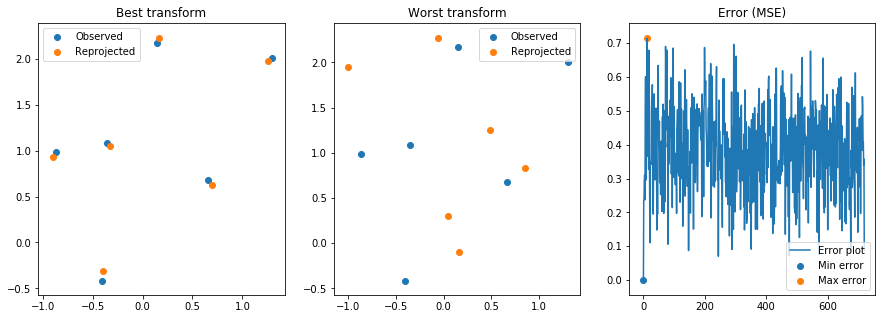

In [172]:
plt.rcParams['figure.figsize'] = [15, 5]

min_error = np.amin(error)
min_error_index = np.argmin(error)
max_error = np.amax(error)
max_error_index = np.argmax(error)

quat_xyz = results[min_error_index]['x']
T = convert_quat_and_cart_to_homogeneous(quat_xyz[:4], quat_xyz[4:])

quat_xyz_worst = results[max_error_index]['x']
T_worst = convert_quat_and_cart_to_homogeneous(quat_xyz_worst[:4], quat_xyz_worst[4:])

plt.figure()
plt.subplot(1,3,1)
plt.scatter(point_positions_noisy_transformed[0,:], point_positions_noisy_transformed[2,:])
plt.scatter((T@point_positions)[0,:], (T@point_positions)[2,:])
plt.legend(['Observed', 'Reprojected'])
plt.title('Best transform')

plt.subplot(1,3,2)
plt.scatter(point_positions_noisy_transformed[0,:], point_positions_noisy_transformed[2,:])
plt.scatter((T_worst@point_positions)[0,:], (T_worst@point_positions)[2,:])
plt.legend(['Observed', 'Reprojected'])
plt.title('Worst transform')

plt.subplot(1,3,3)
plt.plot(error)
plt.title('Error (MSE)')
plt.scatter([min_error_index], [min_error])
plt.scatter([max_error_index], [max_error])
plt.legend(['Error plot','Min error', 'Max error'])
plt.savefig('image_alignment_test.png', bbox_inches='tight')

plt.show()



In [158]:
result

     fun: 0.08881976110134471
     jac: array([-6.34146854e-05,  1.42408535e-05, -4.69656661e-05,  1.88282691e-04,
       -2.66951509e-04,  3.07232141e-04, -6.23995438e-05])
 message: 'Optimization terminated successfully.'
    nfev: 146
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([ 1.66889111, -0.28826658, -0.7719613 ,  0.39133677, -0.25025598,
        0.14235648,  1.43183557])